# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import datetime as dt

# Conexão com o DB local

In [2]:
load_dotenv()

driver = os.environ["Driver"]
server = os.environ["Server"]
database = os.environ["Database"]

In [3]:
dados_conexao = (
    f"Driver={driver};"
    f"Server={server};"
    f"Database={database};"
)

In [4]:
def query_banco(query, dados_conexao):
    engine = create_engine(f'mssql+pyodbc:///?odbc_connect={dados_conexao}')
    return pd.read_sql(query, engine)

# Import dos dados

In [5]:
df_receitas = query_banco("SELECT * FROM Fato_Receita", dados_conexao)
df_receitas.drop(columns=['id','uid_fato_receita'], inplace=True)
df_receitas.rename(columns={'valor':'valor_receita'}, inplace=True)
df_receitas.head()

,cod_receita,data_fato,contribuinte_receita,valor_receita
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27


In [6]:
df_populacao = query_banco("SELECT * FROM Dim_Populacao", dados_conexao)
df_populacao.drop(columns=['id'], inplace=True)
df_populacao

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual
0,1991,51273,0,0,0,0
1,1992,51530,257,"0,5",0,0
2,1993,51965,435,"0,84",178,"69,26"
3,1994,52279,314,"0,6",-121,"-27,82"
4,1995,52586,307,"0,59",-7,"-2,23"
5,1996,51396,-1190,"-2,26",-1497,"-487,62"
6,1997,51575,179,"0,35",1369,"-115,04"
7,1998,51726,151,"0,29",-28,"-15,64"
8,1999,51878,152,"0,29",1,"0,66"
9,2000,54715,2837,"5,47",2685,"1766,45"


In [7]:
df_pib = query_banco("SELECT * FROM Dim_PIB", dados_conexao)
df_pib.drop(columns=['id'], inplace=True)
df_pib.rename(columns={'valor':'valor_pib'}, inplace=True)
df_pib

,ano,valor_pib
0,2006-01-01,342557000
1,2008-01-01,449804000
2,2010-01-01,545321000
3,2012-01-01,688504000
4,2014-01-01,904648000
5,2016-01-01,1039264000
6,2018-01-01,1064232000
7,2020-01-01,1134471000
8,2006-01-01,342557
9,2008-01-01,449804


# Feature engineering

## Inserindo colunas que tratam do tempo

In [8]:
def cria_colunas_tempo(df, coluna_data):
    df[coluna_data] = pd.to_datetime(df[coluna_data])
    df['ano_mes'] = df[coluna_data].dt.strftime('%Y-%m')
    df['ano'] = df[coluna_data].dt.strftime('%Y')
    return df

def transforma_data_em_ordinal(df, coluna_referencia):
    df['ano_mes_ordinal'] = pd.to_datetime(df[coluna_referencia])
    df['ano_mes_ordinal'] = df['ano_mes_ordinal'].map(dt.datetime.toordinal)
    return df

def transforma_coluna_em_datetime(df, coluna):
    df[coluna] = pd.to_datetime(df[coluna], format='%Y')
    return df

## Remoção de outliers

In [9]:
# Aplicação de IQR - Interquartile Range
def remove_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    print(f'Q1: {Q1}')
    Q3 = df[coluna].quantile(0.75)
    print(f'Q3: {Q3}')
    IQR = Q3 - Q1
    print(f'IQR: {IQR}')
    print(f'Limite inferior: {Q1 - 1.5 * IQR}')
    print(f'Limite superior: {Q3 + 1.5 * IQR}')
    df = df[(df[coluna] >= Q1 - 1.5*IQR) & (df[coluna] <= Q3 + 1.5*IQR)]
    print(f'Quantidade de registros sem outliers: {df.shape[0]}')
    return df

# Gráfico de dispersão
def box_plot(df, coluna_referencia, coluna_visao):
    print(f'Quantidade de registros: {df.shape[0]}')
    df.boxplot(by=coluna_referencia, column=coluna_visao, figsize=(10,6))

In [10]:
def plot_series_data(df, coluna_referencia, tipo):
    train_size = int(len(df) * 0.8)
    train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]
    plt.figure(figsize=(20,10))
    plt.plot(train_dataset[coluna_referencia])
    plt.plot(test_dataset[coluna_referencia])
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.legend(['Treino', 'Teste'], loc='upper left')
    plt.savefig(f'../../src/static/images/receitas/dados_treinamento_{tipo}.png')
    plt.show()
    print('Dimension of train data: ', train_dataset.shape)
    print('Dimension of test data: ', test_dataset.shape)

## Conversão de tipos de dados nas colunas

In [11]:
def converte_tipo_dados(df, colunas, tipo):
    for coluna in colunas:
        df[coluna] = df[coluna].astype(tipo)
    return df

# Análise exploratória dos dados

## Receitas

In [12]:
df_receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102293 entries, 0 to 102292
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cod_receita           102293 non-null  int64         
 1   data_fato             102293 non-null  datetime64[ns]
 2   contribuinte_receita  102293 non-null  object        
 3   valor_receita         102293 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [13]:
df_receitas.describe().round(2)

,cod_receita,data_fato,valor_receita
count,1.022930e+05,102293,102293.00
mean,1.256925e+09,2017-11-11 13:19:10.635918336,12522.46
min,1.112500e+08,2013-01-02 00:00:00,-2489288.55
25%,1.113034e+09,2015-07-16 00:00:00,51.23
50%,1.121250e+09,2017-10-13 00:00:00,240.60
75%,1.325000e+09,2020-02-05 00:00:00,1579.25
max,9.728013e+09,2022-12-30 00:00:00,4674330.00
std,1.162115e+09,NaN,89618.73


In [14]:
df_receitas_com_outliers = cria_colunas_tempo(df_receitas,'data_fato')
df_receitas_com_outliers.head()

,cod_receita,data_fato,contribuinte_receita,valor_receita,ano_mes,ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013-01,2013
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,2013-01,2013
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,2013-01,2013
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,2013-01,2013
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,2013-01,2013


Quantidade de registros: 102293


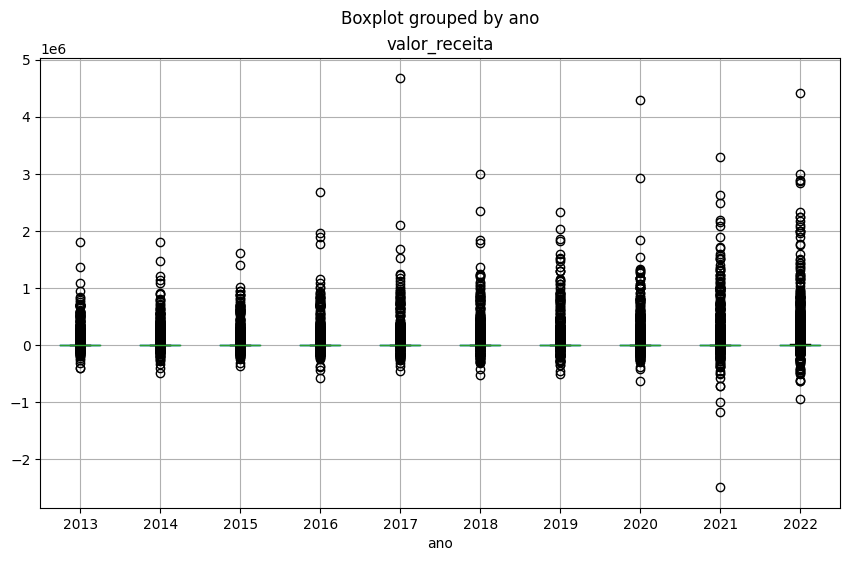

In [15]:
box_plot(df_receitas_com_outliers, 'ano', 'valor_receita')

### DF Sem outliers

In [16]:
df_receitas_sem_outliers = remove_outliers(df_receitas_com_outliers, 'valor_receita')

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


Quantidade de registros: 83736


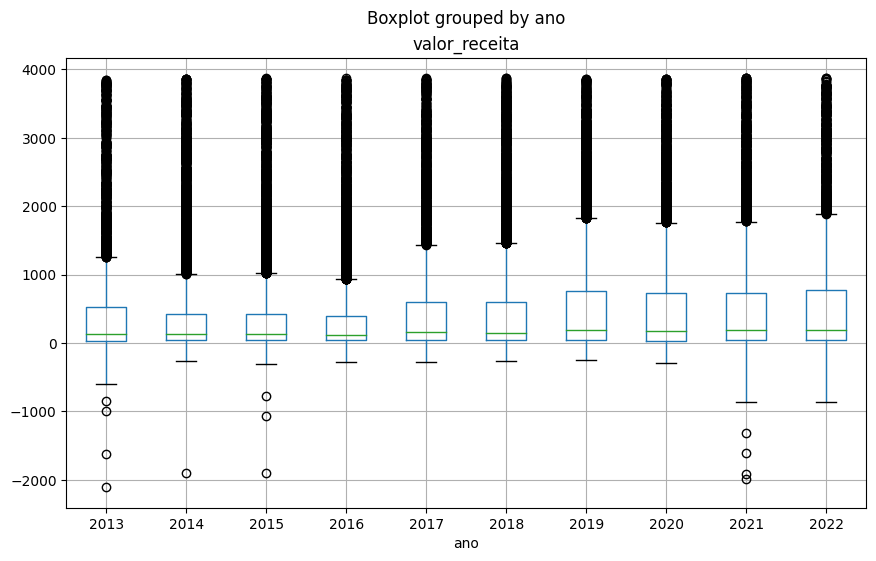

In [17]:
box_plot(df_receitas_sem_outliers, 'ano', 'valor_receita')
# Defina o nome do arquivo de imagem e o local onde deseja salvá-lo.
nome_arquivo = '../../src/static/images/receitas/boxplot_receitas.png'

# Use a função savefig para salvar a imagem.
plt.savefig(nome_arquivo)

# Certifique-se de que a imagem seja salva antes de fechar a janela do gráfico.
plt.show()

## População

In [18]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   ano                                    32 non-null     int64 
 1   populacao                              32 non-null     int64 
 2   variacao_anual                         32 non-null     object
 3   porcentagem_variacao_anual             32 non-null     object
 4   aceleracao_variacao_anual              32 non-null     object
 5   porcentagem_aceleracao_variacao_anual  32 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.6+ KB


In [19]:
df_populacao.describe().round(0)

,ano,populacao
count,32.0,32.0
mean,2006.0,57024.0
std,9.0,4073.0
min,1991.0,51273.0
25%,1999.0,52509.0
50%,2006.0,57065.0
75%,2014.0,61130.0
max,2022.0,63239.0


In [20]:
df_populacao_dados_copy = df_populacao.copy()
df_populacao_dados_convertidos = df_populacao_dados_copy
df_populacao_dados_convertidos['ano'] = df_populacao_dados_convertidos['ano'].astype(object)
df_populacao_dados_convertidos = transforma_coluna_em_datetime(df_populacao, 'ano')
df_populacao_dados_convertidos = cria_colunas_tempo(df_populacao, 'ano')
df_populacao_dados_convertidos['porcentagem_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_variacao_anual'].str.replace(',','.').astype(float)
df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'].str.replace(',','.').astype(float)

In [21]:
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    32 non-null     object 
 1   populacao                              32 non-null     int64  
 2   variacao_anual                         32 non-null     object 
 3   porcentagem_variacao_anual             32 non-null     float64
 4   aceleracao_variacao_anual              32 non-null     object 
 5   porcentagem_aceleracao_variacao_anual  32 non-null     float64
 6   ano_mes                                32 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.9+ KB


In [22]:
df_populacao_dados_convertidos = converte_tipo_dados(df_populacao_dados_convertidos, ['variacao_anual', 'aceleracao_variacao_anual'], 'int64')
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    32 non-null     object 
 1   populacao                              32 non-null     int64  
 2   variacao_anual                         32 non-null     int64  
 3   porcentagem_variacao_anual             32 non-null     float64
 4   aceleracao_variacao_anual              32 non-null     int64  
 5   porcentagem_aceleracao_variacao_anual  32 non-null     float64
 6   ano_mes                                32 non-null     object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.9+ KB


In [23]:
df_populacao_dados_convertidos

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual,ano_mes
0,1991,51273,0,0.00,0,0.00,1991-01
1,1992,51530,257,0.50,0,0.00,1992-01
2,1993,51965,435,0.84,178,69.26,1993-01
3,1994,52279,314,0.60,-121,-27.82,1994-01
4,1995,52586,307,0.59,-7,-2.23,1995-01
5,1996,51396,-1190,-2.26,-1497,-487.62,1996-01
6,1997,51575,179,0.35,1369,-115.04,1997-01
7,1998,51726,151,0.29,-28,-15.64,1998-01
8,1999,51878,152,0.29,1,0.66,1999-01
9,2000,54715,2837,5.47,2685,1766.45,2000-01


## PIB

In [24]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ano        21 non-null     object
 1   valor_pib  21 non-null     object
dtypes: object(2)
memory usage: 468.0+ bytes


In [25]:
df_pib_convertidos = converte_tipo_dados(df_pib, ['valor_pib'], 'float')

In [26]:
# Estimar valores para os anos 2021 e 2022 usando a média das variações anuais
variacoes_anuais = df_pib_convertidos.groupby('ano')['valor_pib'].last().pct_change().mean()
valor_2020 = df_pib_convertidos['valor_pib'].values[-1]
valor_2021_estimado = valor_2020 * (1 + variacoes_anuais)
valor_2022_estimado = valor_2021_estimado * (1 + variacoes_anuais)

In [27]:
df_pib# Criar um novo DataFrame com as linhas para 2021 e 2022
novas_linhas = pd.DataFrame({'ano': [2021, 2022], 'valor_pib': [valor_2021_estimado, valor_2022_estimado]})
novas_linhas = transforma_coluna_em_datetime(novas_linhas, 'ano')

# Concatenar as novas linhas ao DataFrame original
df_pib_convertidos = pd.concat([df_pib_convertidos, novas_linhas], ignore_index=True)
df_pib_convertidos

,ano,valor_pib
0,2006-01-01,3.425570e+08
1,2008-01-01,4.498040e+08
2,2010-01-01,5.453210e+08
3,2012-01-01,6.885040e+08
4,2014-01-01,9.046480e+08
5,2016-01-01,1.039264e+09
6,2018-01-01,1.064232e+09
7,2020-01-01,1.134471e+09
8,2006-01-01,3.425570e+05
9,2008-01-01,4.498040e+05


In [28]:
df_pib_convertidos = cria_colunas_tempo(df_pib_convertidos, 'ano')

In [29]:
df_pib_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ano        23 non-null     object 
 1   valor_pib  23 non-null     float64
 2   ano_mes    23 non-null     object 
dtypes: float64(1), object(2)
memory usage: 684.0+ bytes


In [30]:
df_pib_convertidos

,ano,valor_pib,ano_mes
0,2006,3.425570e+08,2006-01
1,2008,4.498040e+08,2008-01
2,2010,5.453210e+08,2010-01
3,2012,6.885040e+08,2012-01
4,2014,9.046480e+08,2014-01
5,2016,1.039264e+09,2016-01
6,2018,1.064232e+09,2018-01
7,2020,1.134471e+09,2020-01
8,2006,3.425570e+05,2006-01
9,2008,4.498040e+05,2008-01


# Preparo dos df para implementação dos modelos de RN

### Dados da receita + população + pib

In [31]:
df_receitas_sem_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)
df_populacao_dados_convertidos.drop(columns=['porcentagem_variacao_anual', 'porcentagem_aceleracao_variacao_anual','ano_mes'], inplace=True)
df_pib_convertidos.drop(columns=['ano_mes'], inplace=True)

C:\Users\allys\AppData\Local\Temp\ipykernel_33964\3075247237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_receitas_sem_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)


In [32]:
## criando dataframe para os dados com outliers
df_receitas_com_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)

In [33]:
df_receitas_agrupado = df_receitas_sem_outliers.groupby(['ano', 'ano_mes'])['valor_receita'].sum().reset_index()
df_receitas_agrupado = pd.merge(df_receitas_agrupado, df_populacao_dados_convertidos, on='ano', how='left')
df_receitas_agrupado = pd.merge(df_receitas_agrupado, df_pib_convertidos, on='ano', how='left')
df_receitas_agrupado

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,2013,2013-01,160122.33,60612,1482,1146,7.703390e+05
1,2013,2013-02,125630.52,60612,1482,1146,7.703390e+05
2,2013,2013-03,169281.06,60612,1482,1146,7.703390e+05
3,2013,2013-04,161371.68,60612,1482,1146,7.703390e+05
4,2013,2013-05,158982.66,60612,1482,1146,7.703390e+05
...,...,...,...,...,...,...,...
163,2022,2022-08,232355.13,63239,663,376,1.393869e+06
164,2022,2022-09,198234.65,63239,663,376,1.393869e+06
165,2022,2022-10,185469.57,63239,663,376,1.393869e+06
166,2022,2022-11,207671.22,63239,663,376,1.393869e+06


In [34]:
df_receitas_agrupado_outliers = df_receitas_com_outliers.groupby(['ano', 'ano_mes'])['valor_receita'].sum().reset_index()
df_receitas_agrupado_outliers = pd.merge(df_receitas_agrupado_outliers, df_populacao_dados_convertidos, on='ano', how='left')
df_receitas_agrupado_outliers = pd.merge(df_receitas_agrupado_outliers, df_pib_convertidos, on='ano', how='left')
df_receitas_agrupado_outliers

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,2013,2013-01,5865563.10,60612,1482,1146,7.703390e+05
1,2013,2013-02,6979863.94,60612,1482,1146,7.703390e+05
2,2013,2013-03,6038308.84,60612,1482,1146,7.703390e+05
3,2013,2013-04,6036720.77,60612,1482,1146,7.703390e+05
4,2013,2013-05,6566028.25,60612,1482,1146,7.703390e+05
...,...,...,...,...,...,...,...
163,2022,2022-08,15546474.80,63239,663,376,1.393869e+06
164,2022,2022-09,14755666.11,63239,663,376,1.393869e+06
165,2022,2022-10,13494171.35,63239,663,376,1.393869e+06
166,2022,2022-11,14586556.77,63239,663,376,1.393869e+06


### Elaborando metadados

#### Sample dos dados sem outliers - para treinamento da rede

In [35]:
# sample dos dados para as receitas mensais do município
df_receitas_agrupado['SMA(12)'] = df_receitas_agrupado['valor_receita'].rolling(window=12).mean()
df_receitas_agrupado['SMA(6)'] = df_receitas_agrupado['valor_receita'].rolling(window=6).mean()
df_receitas_agrupado['SMA(3)'] = df_receitas_agrupado['valor_receita'].rolling(window=3).mean()
df_receitas_agrupado['SMA(2)'] = df_receitas_agrupado['valor_receita'].rolling(window=2).mean()
df_receitas_agrupado['lag(12)'] = df_receitas_agrupado['valor_receita'].shift(12)
df_receitas_agrupado['lag(6)'] = df_receitas_agrupado['valor_receita'].shift(6)
df_receitas_agrupado['lag(4)'] = df_receitas_agrupado['valor_receita'].shift(4)
df_receitas_agrupado['lag(3)'] = df_receitas_agrupado['valor_receita'].shift(3)
df_receitas_agrupado['lag(2)'] = df_receitas_agrupado['valor_receita'].shift(2)
df_receitas_agrupado['lag(1)'] = df_receitas_agrupado['valor_receita'].shift(1)
df_receitas_agrupado.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,160122.33,60612,1482,1146,770339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,2013-02,125630.52,60612,1482,1146,770339.0,NaN,NaN,NaN,142876.425,NaN,NaN,NaN,NaN,NaN,160122.33
2,2013,2013-03,169281.06,60612,1482,1146,770339.0,NaN,NaN,151677.97,147455.790,NaN,NaN,NaN,NaN,160122.33,125630.52
3,2013,2013-04,161371.68,60612,1482,1146,770339.0,NaN,NaN,152094.42,165326.370,NaN,NaN,NaN,160122.33,125630.52,169281.06
4,2013,2013-05,158982.66,60612,1482,1146,770339.0,NaN,NaN,163211.80,160177.170,NaN,NaN,160122.33,125630.52,169281.06,161371.68


In [36]:
df_receitas_agrupado['SMA(12)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(6)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(3)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(2)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(12)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(6)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(4)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(3)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(2)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(1)'].fillna(0, inplace=True)
df_receitas_agrupado.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,160122.33,60612,1482,1146,770339.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.00,0.00
1,2013,2013-02,125630.52,60612,1482,1146,770339.0,0.0,0.0,0.00,142876.425,0.0,0.0,0.00,0.00,0.00,160122.33
2,2013,2013-03,169281.06,60612,1482,1146,770339.0,0.0,0.0,151677.97,147455.790,0.0,0.0,0.00,0.00,160122.33,125630.52
3,2013,2013-04,161371.68,60612,1482,1146,770339.0,0.0,0.0,152094.42,165326.370,0.0,0.0,0.00,160122.33,125630.52,169281.06
4,2013,2013-05,158982.66,60612,1482,1146,770339.0,0.0,0.0,163211.80,160177.170,0.0,0.0,160122.33,125630.52,169281.06,161371.68


In [37]:
df_receitas_agrupado.drop(columns=['ano'], inplace=True)
df_receitas_agrupado = transforma_data_em_ordinal(df_receitas_agrupado, 'ano_mes')
df_receitas_agrupado.drop(columns=['ano_mes'], inplace=True)
df_receitas_agrupado = df_receitas_agrupado[['ano_mes_ordinal', 'valor_receita', 'SMA(12)', 'SMA(6)', 'SMA(3)', 'SMA(2)', 'lag(12)', 'lag(6)', 'lag(4)', 'lag(3)', 'lag(2)', 'lag(1)', 'populacao', 'variacao_anual', 'aceleracao_variacao_anual', 'valor_pib']]
df_receitas_agrupado.head()

,ano_mes_ordinal,valor_receita,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,734869,160122.33,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.00,0.00,60612,1482,1146,770339.0
1,734900,125630.52,0.0,0.0,0.00,142876.425,0.0,0.0,0.00,0.00,0.00,160122.33,60612,1482,1146,770339.0
2,734928,169281.06,0.0,0.0,151677.97,147455.790,0.0,0.0,0.00,0.00,160122.33,125630.52,60612,1482,1146,770339.0
3,734959,161371.68,0.0,0.0,152094.42,165326.370,0.0,0.0,0.00,160122.33,125630.52,169281.06,60612,1482,1146,770339.0
4,734989,158982.66,0.0,0.0,163211.80,160177.170,0.0,0.0,160122.33,125630.52,169281.06,161371.68,60612,1482,1146,770339.0


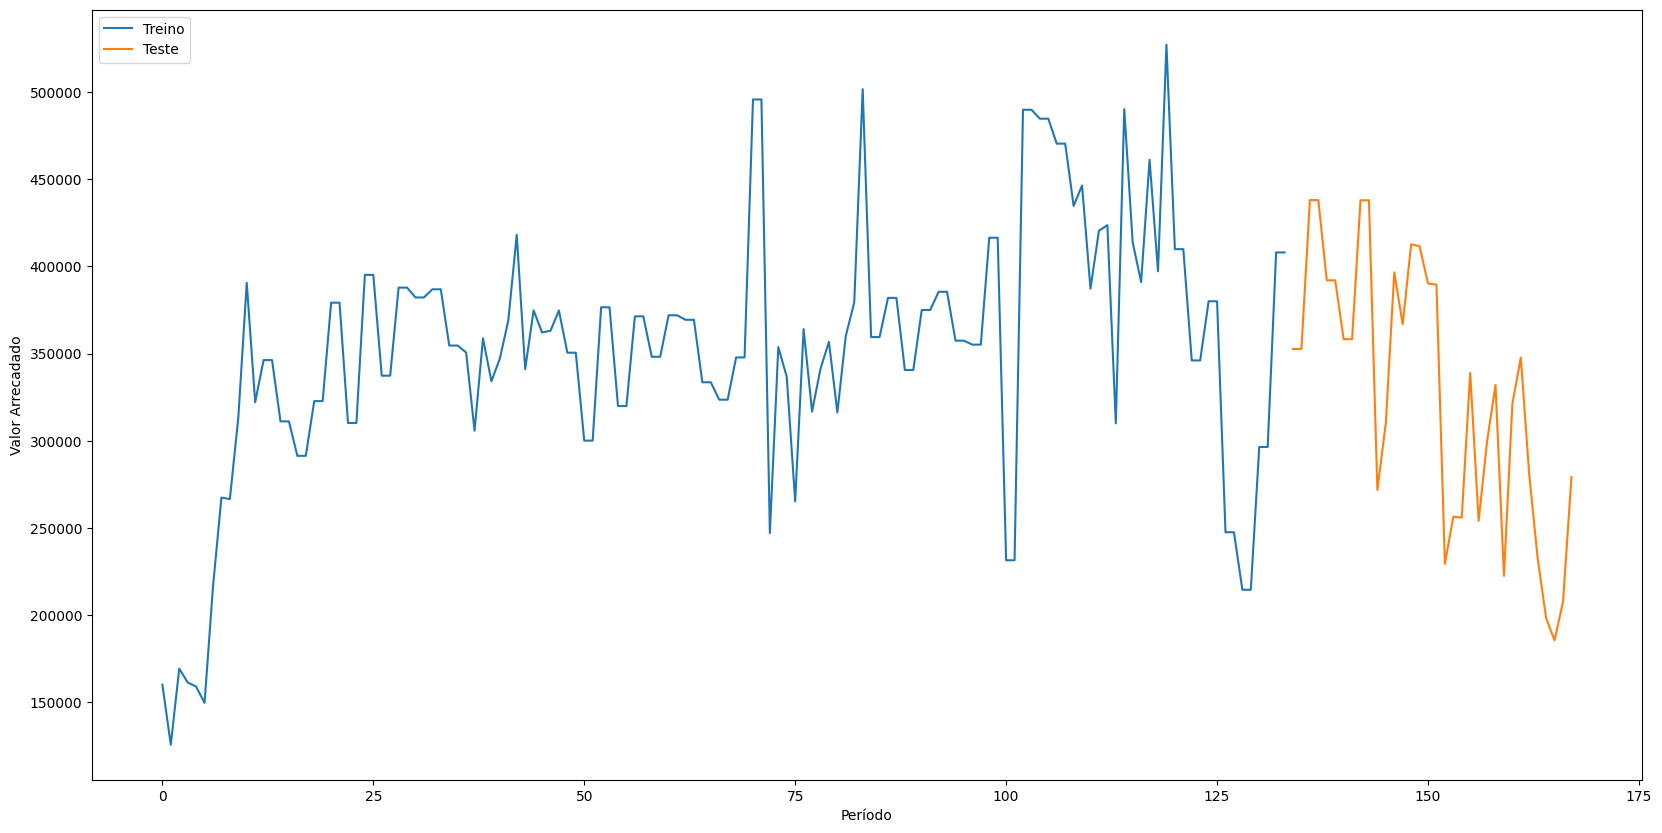

Dimension of train data:  (134, 16)
Dimension of test data:  (34, 16)


In [38]:
plot_series_data(df_receitas_agrupado, 'valor_receita', 'sem_outliers')

In [39]:
df_receitas_agrupado.to_csv('../../data/dados_receitas.csv', index=False, sep=';')

#### Sample dos dados com outliers

In [40]:
# sample dos dados para as receitas mensais do município
df_receitas_agrupado_outliers['SMA(12)'] = df_receitas_agrupado_outliers['valor_receita'].rolling(window=12).mean()
df_receitas_agrupado_outliers['SMA(6)'] = df_receitas_agrupado_outliers['valor_receita'].rolling(window=6).mean()
df_receitas_agrupado_outliers['SMA(3)'] = df_receitas_agrupado_outliers['valor_receita'].rolling(window=3).mean()
df_receitas_agrupado_outliers['SMA(2)'] = df_receitas_agrupado_outliers['valor_receita'].rolling(window=2).mean()
df_receitas_agrupado_outliers['lag(12)'] = df_receitas_agrupado_outliers['valor_receita'].shift(12)
df_receitas_agrupado_outliers['lag(6)'] = df_receitas_agrupado_outliers['valor_receita'].shift(6)
df_receitas_agrupado_outliers['lag(4)'] = df_receitas_agrupado_outliers['valor_receita'].shift(4)
df_receitas_agrupado_outliers['lag(3)'] = df_receitas_agrupado_outliers['valor_receita'].shift(3)
df_receitas_agrupado_outliers['lag(2)'] = df_receitas_agrupado_outliers['valor_receita'].shift(2)
df_receitas_agrupado_outliers['lag(1)'] = df_receitas_agrupado_outliers['valor_receita'].shift(1)
df_receitas_agrupado_outliers.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,5865563.10,60612,1482,1146,770339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,2013-02,6979863.94,60612,1482,1146,770339.0,NaN,NaN,NaN,6422713.520,NaN,NaN,NaN,NaN,NaN,5865563.10
2,2013,2013-03,6038308.84,60612,1482,1146,770339.0,NaN,NaN,6.294579e+06,6509086.390,NaN,NaN,NaN,NaN,5865563.10,6979863.94
3,2013,2013-04,6036720.77,60612,1482,1146,770339.0,NaN,NaN,6.351631e+06,6037514.805,NaN,NaN,NaN,5865563.10,6979863.94,6038308.84
4,2013,2013-05,6566028.25,60612,1482,1146,770339.0,NaN,NaN,6.213686e+06,6301374.510,NaN,NaN,5865563.1,6979863.94,6038308.84,6036720.77


In [41]:
df_receitas_agrupado_outliers['SMA(12)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['SMA(6)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['SMA(3)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['SMA(2)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['lag(12)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['lag(6)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['lag(4)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['lag(3)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['lag(2)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers['lag(1)'].fillna(0, inplace=True)
df_receitas_agrupado_outliers.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,5865563.10,60612,1482,1146,770339.0,0.0,0.0,0.000000e+00,0.000,0.0,0.0,0.0,0.00,0.00,0.00
1,2013,2013-02,6979863.94,60612,1482,1146,770339.0,0.0,0.0,0.000000e+00,6422713.520,0.0,0.0,0.0,0.00,0.00,5865563.10
2,2013,2013-03,6038308.84,60612,1482,1146,770339.0,0.0,0.0,6.294579e+06,6509086.390,0.0,0.0,0.0,0.00,5865563.10,6979863.94
3,2013,2013-04,6036720.77,60612,1482,1146,770339.0,0.0,0.0,6.351631e+06,6037514.805,0.0,0.0,0.0,5865563.10,6979863.94,6038308.84
4,2013,2013-05,6566028.25,60612,1482,1146,770339.0,0.0,0.0,6.213686e+06,6301374.510,0.0,0.0,5865563.1,6979863.94,6038308.84,6036720.77


In [42]:
df_receitas_agrupado_outliers.drop(columns=['ano'], inplace=True)
df_receitas_agrupado_outliers = transforma_data_em_ordinal(df_receitas_agrupado_outliers, 'ano_mes')
df_receitas_agrupado_outliers.drop(columns=['ano_mes'], inplace=True)
df_receitas_agrupado_outliers = df_receitas_agrupado_outliers[['ano_mes_ordinal', 'valor_receita', 'SMA(12)', 'SMA(6)', 'SMA(3)', 'SMA(2)', 'lag(12)', 'lag(6)', 'lag(4)', 'lag(3)', 'lag(2)', 'lag(1)', 'populacao', 'variacao_anual', 'aceleracao_variacao_anual', 'valor_pib']]
df_receitas_agrupado_outliers.head()

,ano_mes_ordinal,valor_receita,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,734869,5865563.10,0.0,0.0,0.000000e+00,0.000,0.0,0.0,0.0,0.00,0.00,0.00,60612,1482,1146,770339.0
1,734900,6979863.94,0.0,0.0,0.000000e+00,6422713.520,0.0,0.0,0.0,0.00,0.00,5865563.10,60612,1482,1146,770339.0
2,734928,6038308.84,0.0,0.0,6.294579e+06,6509086.390,0.0,0.0,0.0,0.00,5865563.10,6979863.94,60612,1482,1146,770339.0
3,734959,6036720.77,0.0,0.0,6.351631e+06,6037514.805,0.0,0.0,0.0,5865563.10,6979863.94,6038308.84,60612,1482,1146,770339.0
4,734989,6566028.25,0.0,0.0,6.213686e+06,6301374.510,0.0,0.0,5865563.1,6979863.94,6038308.84,6036720.77,60612,1482,1146,770339.0


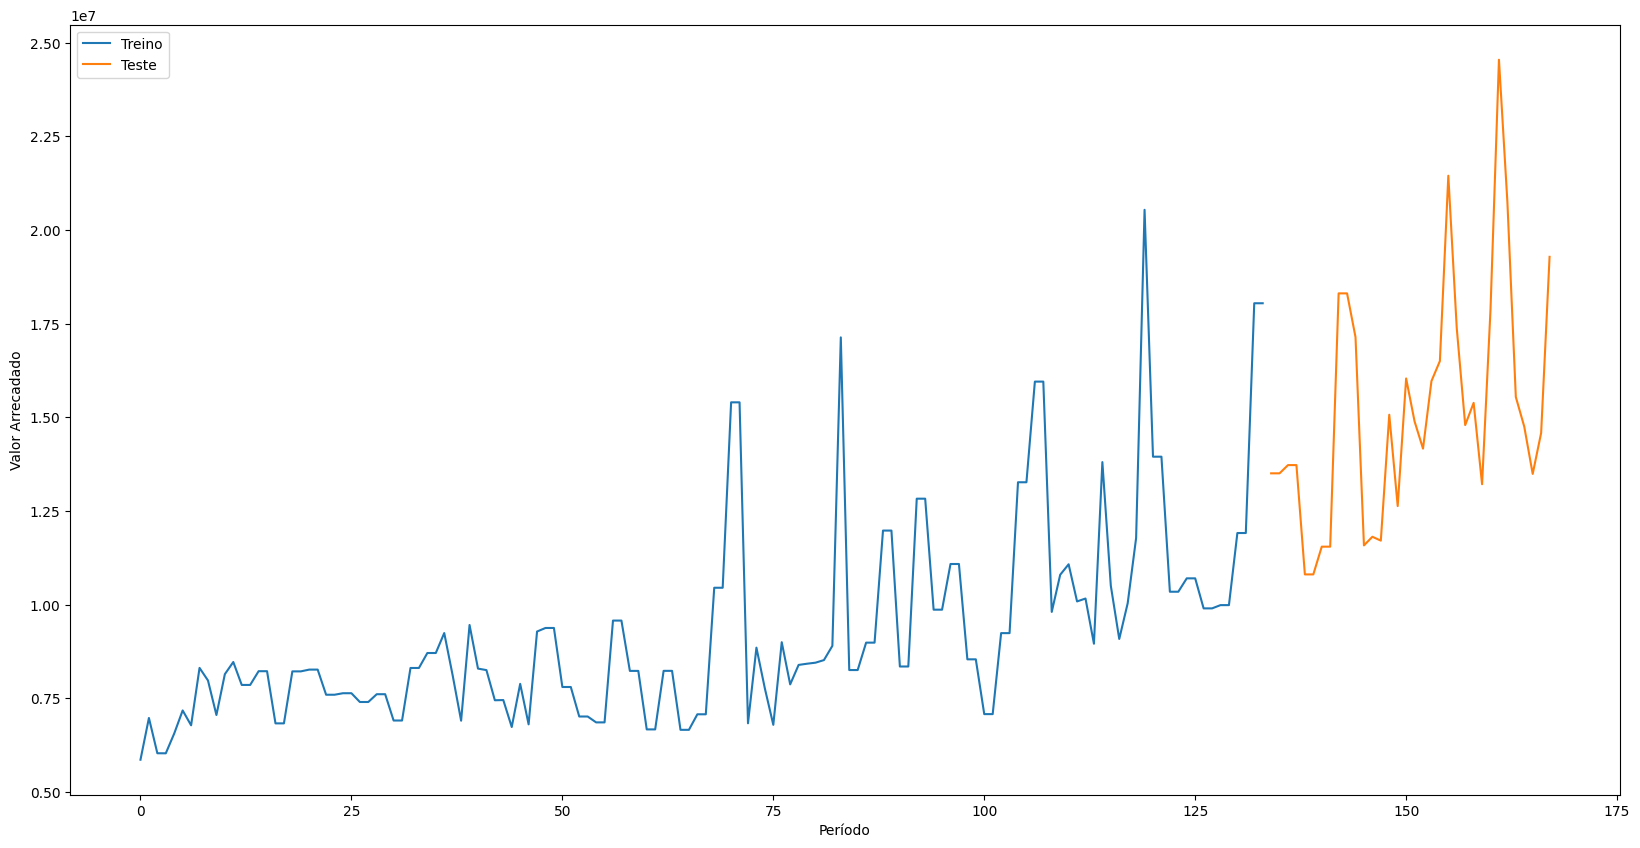

Dimension of train data:  (134, 16)
Dimension of test data:  (34, 16)


In [43]:
plot_series_data(df_receitas_agrupado_outliers, 'valor_receita', 'com_outliers')

In [44]:
df_receitas_agrupado_outliers.to_csv('../../data/dados_receitas_com_outliers.csv', index=False, sep=';')

### Modelagem dos dados

In [45]:
train_size = int(len(df_receitas_agrupado) * 0.75)
train_dataset, test_dataset = df_receitas_agrupado_outliers.iloc[:train_size], df_receitas_agrupado_outliers.iloc[train_size:]

In [46]:
X_train = train_dataset.drop(['valor_receita'], axis=1)
y_train = train_dataset.loc[:, ['valor_receita']]

In [47]:
X_test = test_dataset.drop(['valor_receita'], axis=1)
y_test = test_dataset.loc[:, ['valor_receita']]

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

In [49]:
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

In [50]:
# normalizando os dados de treino e teste
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [51]:
X_test = test_x_norm.reshape((test_x_norm.shape[0], 1, test_x_norm.shape[1]))
X_train = train_x_norm.reshape((train_x_norm.shape[0], 1, train_x_norm.shape[1]))
y_test = test_y_norm.reshape((test_y_norm.shape[0], 1))
y_train = train_y_norm.reshape((train_y_norm.shape[0], 1))

Ajuste no modelo com 32, 64 e 128 neurônios para verficação do mais adequado para a aplicação.

Epoch 1/100
25/25 [==============================] - 6s 55ms/step - loss: 0.0210 - val_loss: 0.0702
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0611
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0610
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0587
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0137 - val_loss: 0.0567
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0530
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0508
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0495
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0475
Epoch 10/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0455
Epoch 11

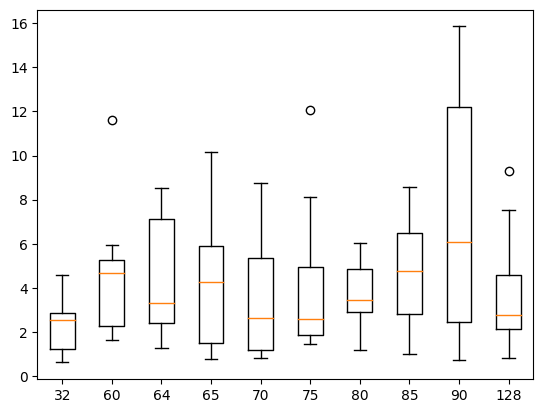

In [52]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, neurons):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = neurons))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}, Std={s:.3f}')
    # boxplot das pontuações
    plt.boxplot(scores, labels=params)
    plt.savefig('../../src/static/images/receitas/figura[0].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score * 100.0
            scores.append(score)
            print(f'>Neurons={p}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = [32, 60, 64, 65, 70, 75, 80, 85, 90, 128]
run_experiment(n_params)

Ajuste de modelo com tamanho do lote 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 e 12, para verificação do mais adequado para a aplicação.

Epoch 1/50
100/100 [==============================] - 11s 28ms/step - loss: 0.0140 - val_loss: 0.0353
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0165 - val_loss: 0.0334
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0129 - val_loss: 0.0315
Epoch 4/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0120 - val_loss: 0.0315
Epoch 5/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0114 - val_loss: 0.0271
Epoch 6/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0241
Epoch 7/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0100 - val_loss: 0.0219
Epoch 8/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0102 - val_loss: 0.0195
Epoch 9/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0097 - val_loss: 0.0163
Epoch 10/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0088 - val_loss: 0.01

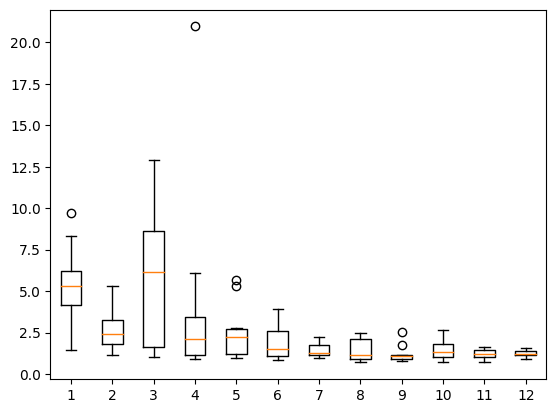

In [53]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = 80))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}, Std={s:.3f}')
    # boxplot das pontuações
    plt.boxplot(scores, labels=params)
    plt.savefig('../../src/static/images/receitas/figura[1].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score * 100.0
            scores.append(score)
            print(f'>p={p}: {r+1}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = np.arange(1, 13)
run_experiment(n_params)

Ajuste no modelo com diluição - dropout - 0.05, 0.1, 0.2, 0.3, para verficação do mais adequado para a aplicação.

Epoch 1/50
20/20 [==============================] - 5s 58ms/step - loss: 0.0206 - val_loss: 0.0500
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0653
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0145 - val_loss: 0.0559
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0138 - val_loss: 0.0514
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0485
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0439
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0401
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0369
Epoch 9/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0345
Epoch 10/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0299
Epoch 11/50
20/20

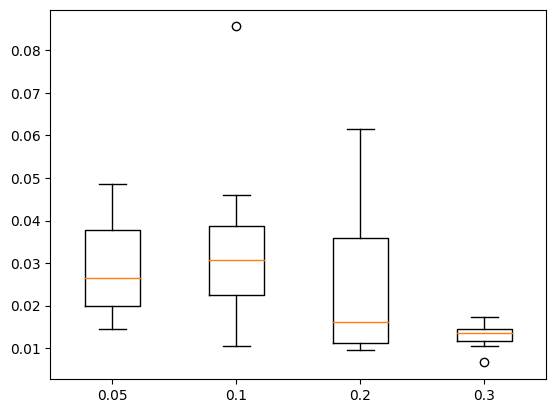

In [54]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = 80))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=5)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}:, Std={s:.3f}')
    # boxplot das pontuações
    plt.boxplot(scores, labels=params)
    plt.savefig('../../src/static/images/receitas/figura[2].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score
            scores.append(score)
            print(f'>p={p}: {r+1}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = [0.05, 0.1, 0.2, 0.3]
run_experiment(n_params)

Ajustando o modelo com os padrões mais adequados visualizados nos testes anteriores.
<p>Neurônios = 32</p>
<p>Tamanho do lote/batch = 11</p>
<p>Dropout = 0.3</p>

In [56]:
neurons = 32
batch_size = 11
dropout = 0.3

In [57]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = neurons))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=150, batch_size=batch_size, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
    return loss

# Resumindo as pontuações
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print(f'Loss: Mean = {m:.3f}, Std = {s:.3f}')

# Rodando um experimento
def run_experiment(repeats = 10):
    # repetindo o experimento
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score
        scores.append(score)
        print(f'>{r+1}: Score={score}')
    # resumindo os resultados
    summarize_results(scores)

# Rodando o experimento
run_experiment()

Epoch 1/150
10/10 [==============================] - 8s 142ms/step - loss: 0.0330 - val_loss: 0.1193
Epoch 2/150
10/10 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss: 0.0774
Epoch 3/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0129 - val_loss: 0.0565
Epoch 4/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0165 - val_loss: 0.0589
Epoch 5/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0137 - val_loss: 0.0644
Epoch 6/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0147 - val_loss: 0.0631
Epoch 7/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0132 - val_loss: 0.0607
Epoch 8/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0155 - val_loss: 0.0620
Epoch 9/150
10/10 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0645
Epoch 10/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0597
Epoch

### Criando modelo

In [58]:
def create_model(units, dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = units))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    return model

In [59]:
def fit_model(model):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=150, batch_size=batch_size, validation_split = 0.2, shuffle=False, callbacks=[early_stop])
    return history

In [60]:
model_lstm = create_model(neurons, dropout)
history_lstm = fit_model(model_lstm)

Epoch 1/150
10/10 [==============================] - 7s 143ms/step - loss: 0.0386 - val_loss: 0.1270
Epoch 2/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0201 - val_loss: 0.0821
Epoch 3/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0590
Epoch 4/150
10/10 [==============================] - 0s 10ms/step - loss: 0.0155 - val_loss: 0.0570
Epoch 5/150
10/10 [==============================] - 0s 8ms/step - loss: 0.0160 - val_loss: 0.0607
Epoch 6/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0162 - val_loss: 0.0601
Epoch 7/150
10/10 [==============================] - 0s 10ms/step - loss: 0.0144 - val_loss: 0.0589
Epoch 8/150
10/10 [==============================] - 0s 8ms/step - loss: 0.0149 - val_loss: 0.0599
Epoch 9/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0152 - val_loss: 0.0588
Epoch 10/150
10/10 [==============================] - 0s 9ms/step - loss: 0.0127 - val_loss: 0.0567
Epoch

### Salvando modelo:

In [61]:
model_lstm.save('receitas_2013_2022')

INFO:tensorflow:Assets written to: receitas_2013_2022\assets


INFO:tensorflow:Assets written to: receitas_2013_2022\assets


### Carga do modelo salvo:

In [62]:
model_lstm = tf.keras.models.load_model('receitas_2013_2022')

Pré-processamento e predição da base de testes com a utilização do modelo carregado:

In [63]:
def prediction(model):
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [64]:
def plot_future(prediction, y_test):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predição')
    plt.legend(loc='upper left')
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig('../../src/static/images/receitas/figura[3].png')
    plt.show()

In [65]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

prediction_lstm = prediction(model_lstm)

2/2 [==============================] - 1s 0s/step


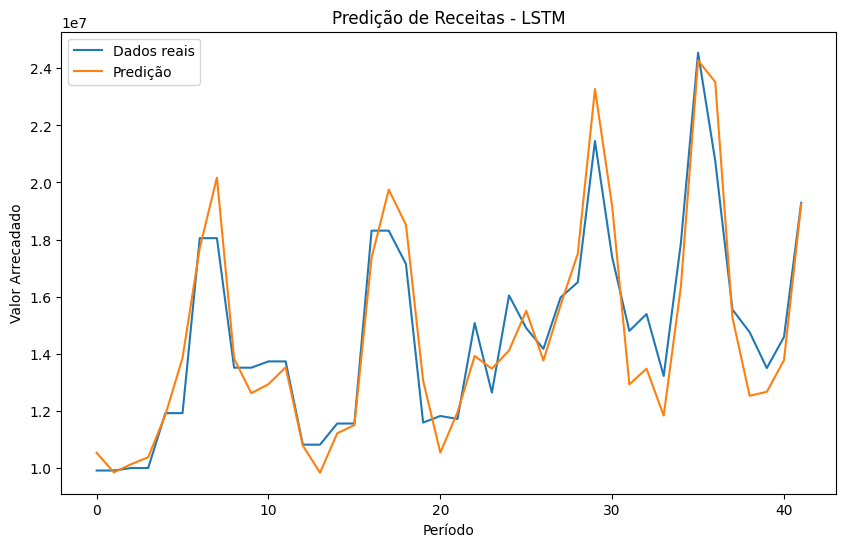

In [66]:
plot_future(prediction_lstm, y_test)

Cálculo do erro médio absoluto e raiz quadrática média:

In [67]:
def evaluate_prediction(prediction_lstm, actual, model_name):
    errors = prediction_lstm - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(f'{model_name}:')
    print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')

In [68]:
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

LSTM:
MSE: 1423784814977.77, RMSE: 1193224.55, MAE: 947733.83


Pré-processamento dos dados e aplicação do modelo em toda a base de dados (treino + teste):

In [69]:
def prediction(model):
    y_pred = model.predict(X)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [70]:
def plot_future(prediction, y):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predição')
    plt.legend(loc='upper left')
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig('../../src/static/images/receitas/figura[4].png')
    plt.show()

6/6 [==============================] - 0s 3ms/step


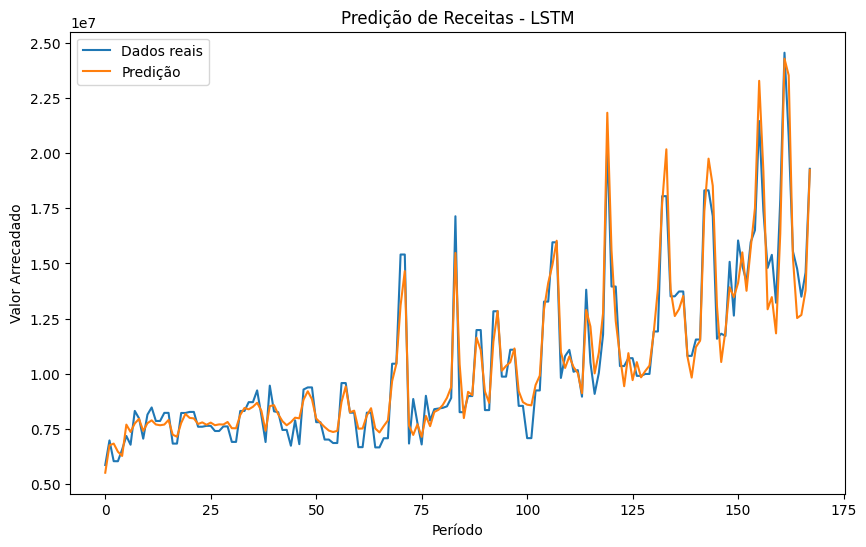

In [71]:
X = df_receitas_agrupado_outliers.drop(['valor_receita'], axis=1)
y = df_receitas_agrupado_outliers.loc[:, ['valor_receita']]

y_norm = output_scaler.transform(y)
X_norm = input_scaler.transform(X)

X = X_norm.reshape((X_norm.shape[0], 1, X_norm.shape[1]))
y = y_norm.reshape((y_norm.shape[0], 1))

y = scaler_y.inverse_transform(y)

prediction_lstm = prediction(model_lstm)

plot_future(prediction_lstm, y)

Cálculo do erro médio percentual:

In [72]:
real = y.flatten()
previsto = prediction_lstm.flatten()

tabela = pd.DataFrame([real, previsto]).T
tabela = tabela.rename(columns={0: 'Real', 1: 'Previsto'})
tabela['Diferenca'] = 1 - (tabela['Real'] / tabela['Previsto'])
media_tabela = tabela['Diferenca'].mean() * 100
print(f'Erro médio percentual: {media_tabela:.2f}%')

Erro médio percentual: 0.57%


Distribuição de erros:

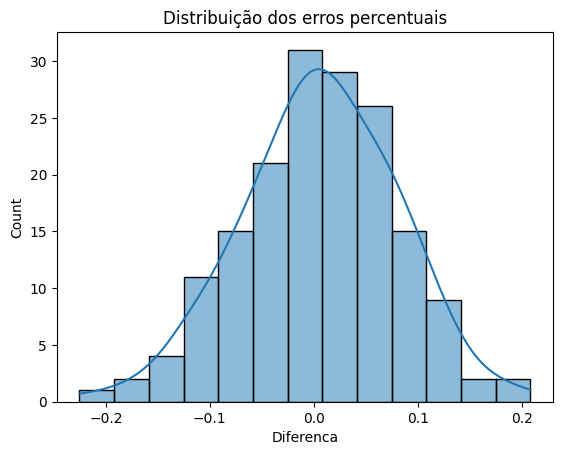

In [73]:
import seaborn as sns

sns.histplot(data=tabela, x='Diferenca', kde=True).set_title('Distribuição dos erros percentuais').get_figure().savefig('../../src/static/images/receitas/figura[5].png')

Relizando previsões com os dados e modelo treinado

In [74]:
previsao = df_receitas_agrupado_outliers

previsao

,ano_mes_ordinal,valor_receita,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,734869,5865563.10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,60612,1482,1146,7.703390e+05
1,734900,6979863.94,0.000000e+00,0.000000e+00,0.000000e+00,6.422714e+06,0.00,0.00,0.00,0.00,0.00,5865563.10,60612,1482,1146,7.703390e+05
2,734928,6038308.84,0.000000e+00,0.000000e+00,6.294579e+06,6.509086e+06,0.00,0.00,0.00,0.00,5865563.10,6979863.94,60612,1482,1146,7.703390e+05
3,734959,6036720.77,0.000000e+00,0.000000e+00,6.351631e+06,6.037515e+06,0.00,0.00,0.00,5865563.10,6979863.94,6038308.84,60612,1482,1146,7.703390e+05
4,734989,6566028.25,0.000000e+00,0.000000e+00,6.213686e+06,6.301375e+06,0.00,0.00,5865563.10,6979863.94,6038308.84,6036720.77,60612,1482,1146,7.703390e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,738368,15546474.80,1.730145e+07,1.789007e+07,2.028313e+07,1.815041e+07,14895904.74,14796988.62,13218515.53,17882570.38,24548567.19,20754348.32,63239,663,376,1.393869e+06
164,738399,14755666.11,1.735041e+07,1.778436e+07,1.701883e+07,1.515107e+07,14168150.37,15389970.91,17882570.38,24548567.19,20754348.32,15546474.80,63239,663,376,1.393869e+06
165,738429,13494171.35,1.714406e+07,1.783030e+07,1.459877e+07,1.412492e+07,15970308.83,13218515.53,24548567.19,20754348.32,15546474.80,14755666.11,63239,663,376,1.393869e+06
166,738460,14586556.77,1.698410e+07,1.728096e+07,1.427880e+07,1.404036e+07,16506070.90,17882570.38,20754348.32,15546474.80,14755666.11,13494171.35,63239,663,376,1.393869e+06


In [75]:
periodo = 1  # escolha o período de previsão à frente será executado

for i in range(periodo):
    # Crie uma nova linha de dados vazia
    row = pd.DataFrame(columns=previsao.columns)

    # Calcule as médias e valores de atraso
    row.loc[0, 'SMA(12)'] = previsao['valor_receita'].iloc[-12:].mean()
    row.loc[0, 'SMA(6)'] = previsao['valor_receita'].iloc[-6:].mean()
    row.loc[0, 'SMA(3)'] = previsao['valor_receita'].iloc[-3:].mean()
    row.loc[0, 'SMA(2)'] = previsao['valor_receita'].iloc[-2:].mean()
    row.loc[0, 'lag(12)'] = previsao['valor_receita'].iloc[-12]
    row.loc[0, 'lag(6)'] = previsao['valor_receita'].iloc[-6]
    row.loc[0, 'lag(4)'] = previsao['valor_receita'].iloc[-4]
    row.loc[0, 'lag(3)'] = previsao['valor_receita'].iloc[-3]
    row.loc[0, 'lag(2)'] = previsao['valor_receita'].iloc[-2]
    row.loc[0, 'lag(1)'] = previsao['valor_receita'].iloc[-1]
    row.loc[0, 'populacao'] = previsao['populacao'].iloc[-1]
    row.loc[0, 'variacao_anual'] = previsao['variacao_anual'].iloc[-1]
    row.loc[0, 'aceleracao_variacao_anual'] = previsao['aceleracao_variacao_anual'].iloc[-1]
    row.loc[0, 'valor_pib'] = previsao['valor_pib'].iloc[-1]


    # Incremente a data
    row.loc[0, 'ano_mes_ordinal'] = previsao['ano_mes_ordinal'].iloc[-1]+1
    
    # Excluindo a coluna de valor arrecadado
    row = row.drop(columns={'valor_receita'})
    
    # Transforme a linha em um array e normalize
    row = np.array(row.iloc[-1]).reshape(1, -1)
    row_norm = input_scaler.transform(row)

    # Preveja usando o modelo LSTM
    to_prev = row_norm.reshape((row_norm.shape[0], 1, row_norm.shape[1]))
    prev = model_lstm.predict(to_prev)
    prev = scaler_y.inverse_transform(prev)

    # Crie um DataFrame com a previsão e adicione ao DataFrame principal
    row_ = pd.DataFrame(row, columns = ['ano_mes_ordinal', 'SMA(12)', 'SMA(6)', 'SMA(3)', 'SMA(2)', 'lag(12)', 'lag(6)', 'lag(4)', 'lag(3)', 'lag(2)', 'lag(1)', 'populacao', 'variacao_anual', 'aceleracao_variacao_anual', 'valor_pib'])
    row_.loc[0, 'valor_receita'] = prev[0]
    previsao = pd.concat([previsao, row_], ignore_index=True)

previsao

1/1 [==============================] - 0s 34ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,ano_mes_ordinal,valor_receita,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,734869,5865563.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60612,1482,1146,770339.0
1,734900,6979863.94,0.0,0.0,0.0,6422713.52,0.0,0.0,0.0,0.0,0.0,5865563.1,60612,1482,1146,770339.0
2,734928,6038308.84,0.0,0.0,6294578.626667,6509086.39,0.0,0.0,0.0,0.0,5865563.1,6979863.94,60612,1482,1146,770339.0
3,734959,6036720.77,0.0,0.0,6351631.183333,6037514.805,0.0,0.0,0.0,5865563.1,6979863.94,6038308.84,60612,1482,1146,770339.0
4,734989,6566028.25,0.0,0.0,6213685.953333,6301374.51,0.0,0.0,5865563.1,6979863.94,6038308.84,6036720.77,60612,1482,1146,770339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,738399,14755666.11,17350408.259167,17784357.055,17018829.743333,15151070.455,14168150.37,15389970.91,17882570.38,24548567.19,20754348.32,15546474.8,63239,663,376,1393868.928021
165,738429,13494171.35,17144063.469167,17830299.691667,14598770.753333,14124918.73,15970308.83,13218515.53,24548567.19,20754348.32,15546474.8,14755666.11,63239,663,376,1393868.928021
166,738460,14586556.77,16984103.958333,17280964.09,14278798.076667,14040364.06,16506070.9,17882570.38,20754348.32,15546474.8,14755666.11,13494171.35,63239,663,376,1393868.928021
167,738490,19287535.92,16803670.078333,16404125.545,15789421.346667,16937046.345,21452742.48,24548567.19,15546474.8,14755666.11,13494171.35,14586556.77,63239,663,376,1393868.928021
